# Low-dimensional linear programming

*Note: this is a brief overview of this notebook. More project details will be provided in the in-class presentation.*

In this notebook, we study Megiddo's algorithm for linear programming in $\mathbb{R}^2$. This algorithm runs in $O(n)$ and thus has better asymptotic complexity properties than the widely used simplex method, which may run in exponential time in some cases. Because Megiddo's algorithm takes advantage of properties of the 2D Euclidean plane, it is arguably more interesting than the simplex method with respect to the techniques that we have learned this semester.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

## Linear programs
Recall that a *linear program* is a convex optimization problem in $n$ variables and $m$ constraints with the form

\begin{equation*}
\begin{array}{ll@{}ll} 
\text{minimize}  & \mathbf{c}^T \mathbf{x} \\
\text{subject to}& A \mathbf{x} \leq \mathbf{\beta}
\end{array}
\end{equation*}

where $c, x \in \mathbb{R}^n$, $A \in \mathbb{R}^{m \times n}$, and $\mathbf{\beta} \in \mathbb{R}^m$. For this project, we fix $n=2$.

Megiddo notes that we can apply a duality transformation and rewrite 2D linear programs such that the $y$-coordinate is minimized; thus, the coefficient of the objective is encoded in the constraints. 

In [429]:
def plot_2d_constraints(A, b, xmin=-10, xmax=10, ymin=-10, ymax=10, alpha=0.15, epsilon=1e-16):
    """Plots a set of 2D linear constraints in canonical LP form."""
    for (x_coeff, y_coeff), c in zip(A, b):
        xc = epsilon if x_coeff == 0 else x_coeff
        yc = epsilon if y_coeff == 0 else y_coeff
        m = -xc / yc
        b = c / yc
        x_range = [xmin, xmax]
        endpoints = [xmin * m + b, xmax * m + b]
        constraint = plt.plot(x_range, endpoints,
                              label='{:.1f}x + {:.1f}y ≤ {:.1f}'.format(x_coeff, y_coeff, c))
        if y_coeff > 0:
            plt.fill_between(x_range, endpoints, ymin, alpha=alpha)
        else:
            plt.fill_between(x_range, endpoints, ymax, alpha=alpha)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.legend()

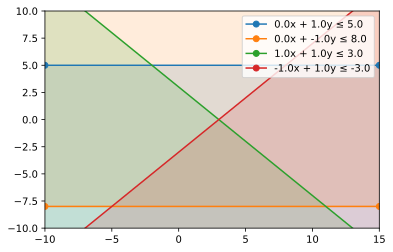

In [430]:
A1 = np.array([
    [0, 1],
    [0, -1],
    [1, 1],
    [-1, 1]
])
b1 = np.array([5, 8, 3, -3])
plot_2d_constraints(A1, b1, xmax=15)

### Separating into $I_1$ and $I_2$

We convert constraints from standard form to point-slope form. We do not allow vertical constraints (bounds on x); these are passed as separate parameters to the algorithm. 

We then separate the constraints into $I_1$ (the "above" constraints) and $I_2$ (the "below constraints"). $I_1$ forms the lower part of the feasible region, if it exists; thus we seek to minimize $y$ on $I_1$.

In [4]:
def separate_constraints(A, b):
    """Separate y ≥ ax + b constraints (I1) from y ≤ ax + b constraints (I2)"""
    I1 = []
    I2 = []
    for (x_coeff, y_coeff), c in zip(A, b):
        if y_coeff < 0:
            I1.append((-x_coeff / y_coeff, c / y_coeff))
        elif y_coeff == 0:
            print('Skipping vertical constraint.')
        else:
            I2.append((-x_coeff / y_coeff, c / y_coeff))
    return I1, I2

In [5]:
def filter_constraints(I, a, b, above=True):
    I = I.copy()
    if len(I) == 1:
        return I, []
    if len(I) % 2 == 1:
            # Add a dummy redundant constraint to yield
            # an even number of constraints.
            I.append(I[-1])
            
    next_I = []
    x_vals = []
    for p_i, p_j in zip(I[::2], I[1::2]):
        a_i, b_i = p_i
        a_j, b_j = p_j
        if a_i == a_j:
            # For two constraints with the same slope,
            # drop the less restrictive constraint.
            if (b_i > b_j and above) or (b_j > b_i and not above):
                next_I.append((a_j, b_j))
            else:
                next_I.append((a_i, b_i))
            continue
        x_ij = (b_i - b_j) / (a_j - a_i)
        x_vals.append(x_ij)
        if x_ij <= a:
            # For the entirety of the search interval, the line with
            # smaller slope is more constraining. Drop the line with
            # larger slope.
            if (a_i > a_j and above) or (a_j > a_i and not above):
                next_I.append((a_i, b_i))
            else:
                next_I.append((a_j, b_j))
            continue
        elif x_ij >= b:
            # For the entirety of the search interval, the line with
            # larger slope is more constraining. Drop the line with
            # smaller slope.
            if (a_i < a_j and above) or (a_j < a_i and not above):
                next_I.append((a_i, b_i))
            else:
                next_I.append((a_j, b_j))
            continue
        # For some iterations, it may not be possible to remove
        # constraints.
        next_I.append((a_i, b_i))
        next_I.append((a_j, b_j))
    return next_I, x_vals

In [6]:
def megiddo(I1, I2, a, b, max_iters=100, epsilon=1e-8, debug=False):
    steps = [(I1, I2, None, a, b)]
    for _ in range(max_iters):
        I1, x_vals_above = filter_constraints(I1, a, b, above=True)
        I2, x_vals_below = filter_constraints(I2, a, b, above=False)
        x_vals = x_vals_above + x_vals_below
        if not I1 or not I2 or not x_vals:
            break
        x_median = np.median(x_vals)
        steps.append((I1, I2, x_median, a, b))
        g_x = max(x_median * a_i + b_i for a_i, b_i in I1)
        h_x = min(x_median * a_i + b_i for a_i, b_i in I2)
        s_g = min(a_i for a_i, b_i in I1 if abs(x_median * a_i + b_i - g_x) < epsilon)
        S_g = max(a_i for a_i, b_i in I1 if abs(x_median * a_i + b_i - g_x) < epsilon)
        s_h = min(a_i for a_i, b_i in I2 if abs(x_median * a_i + b_i - h_x) < epsilon)
        S_h = max(a_i for a_i, b_i in I2 if abs(x_median * a_i + b_i - h_x) < epsilon)
        if debug:
            print('s_g:', s_g)
            print('S_g:', S_g)
            print('s_h:', s_h)
            print('S_h:', S_h)
            print('x:', x_median)
            print('g(x):', g_x)
            print('h(x):', h_x)
            print('a:', a)
            print('b:', b)
            print('|I1| + |I2|:', len(I1) + len(I2))
            print('---------')
        
        if g_x > h_x:
            # Case 1: x is currently infeasible.
            if s_g > S_h:
                # The feasible region lies to the left of x_median.
                b = x_median
            elif S_g > s_h:
                # The feasible region lies to the right of x_median.
                a = x_median
            else:
                # The problem is known to be infeasible.
                break
        elif g_x < h_x:
            # Case 2: x is currently feasible and the height
            # of the feasible region at x is nonzero. Is x optimal?
            # ***NOTE***: The original Megiddo paper seems to have a
            # typo/inconsistency in it here. (it states that the conditions
            # for the first branch are s_g > 0 *or* S_g < 0).
            if s_g > 0:  
                # x is currently too big!
                b = x_median
            elif S_g < 0:
                # x is currently too small!
                a = x_median
            else:
                # We have found the optimal solution.
                return {'status': 'optimal', 'value': x_median, 'steps': steps}
        else:
            # Case 3: x is currently feasible and the height
            # of the feasible region at x is nonzero (that is, g_x == h_x).
            # Is x optimal?
            if s_g > 0 and s_g >= S_h:
                # x is currently too big!
                b = x_median
            elif S_g < 0 and S_g >= s_h:
                # x is currently too small!
                a = x_median
            else:
                # We have found the optimal solution.
                return {'status': 'optimal', 'value': x_median, 'steps': steps}
            
    if a == float('-inf') or b == float('inf'):
        return {'status': 'infeasible or unbounded', 'value': None, 'steps': steps}
    else:
        # It is possible to have a scenario where g(x) - h(x) is negatively
        # unbounded except by the initial x-bounds ([a, b]). The Megiddo
        # algorithm does not examine these endpoints when finding the median
        # x-value---it only considers intersection points. We can check the
        # endpoints explicitly if the problem is not x-unbounded.
        x_last = x_median
        g_x_last = max(x_last * a_i + b_i for a_i, b_i in I1) 
        for x in (a, b):
            g_x = max(x * a_i + b_i for a_i, b_i in I1)
            h_x = min(x * a_i + b_i for a_i, b_i in I2)
            if g_x <= h_x and g_x < g_x_last:
                x_last = x
                g_x_last = g_x
        if x_last != x_median:
            steps.append((I1, I2, x_last, x_last, x_last))
            return {'status': 'optimal', 'value': x, 'steps': steps}
    return {'status': 'infeasible', 'value': None, 'steps': steps}

## Viewing the solution
The `megiddo()` function saves intermediate steps for inspection. We can also visualize $g(x)$, $h(x)$, and the location of $x'$ at each step.

In [7]:
I1, I2 = separate_constraints(A1, b1)
solution_A1 = megiddo(I1, I2, -20, 20, debug=False)
solution_A1

{'status': 'optimal',
 'value': -2.0,
 'steps': [([(-0.0, -8.0)],
   [(0.0, 5.0), (-1.0, 3.0), (1.0, -3.0)],
   None,
   -20,
   20),
  ([(-0.0, -8.0)], [(0.0, 5.0), (-1.0, 3.0), (1.0, -3.0)], -2.0, -20, 20)]}

In [8]:
def show_megiddo(steps):
    I1, I2, _, a_init, b_init = steps[0]
    xmin = a_init - 20
    xmax = b_init + 20
    step_values = [s[2] for s in steps]
    x_range = np.linspace(xmin, xmax, 100)
    if I1:
        g = [max(x * a_i + b_i for a_i, b_i in I1) for x in x_range]
    else:
        g = []
    if I2:
        h = [min(x * a_i + b_i for a_i, b_i in I2) for x in x_range]
    else:
        h = []
    for idx, step in enumerate(steps):
        _, _, value, a, b = step
        if g:
            plt.plot(x_range, g, color='red', label='g(x) [below]')
        if h:
            plt.plot(x_range, h, color='blue', label='h(x) [above]')
        if value is not None:
            plt.axvline(value, color='black', linestyle='--')
        plt.axvline(a, color='gray', linestyle=':')
        plt.axvline(b, color='gray', linestyle=':')
        plt.title(f'Step {idx}')
        plt.legend()
        plt.xlim(xmin, xmax)
        plt.show()

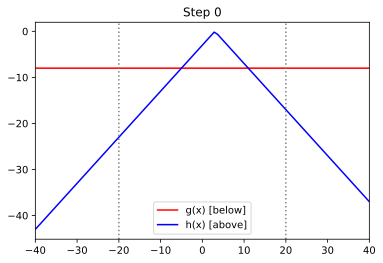

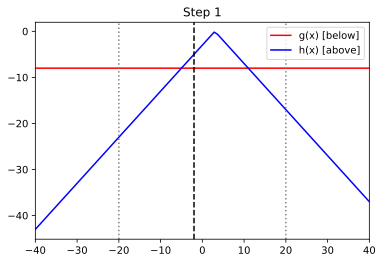

In [9]:
show_megiddo(solution_A1['steps'])

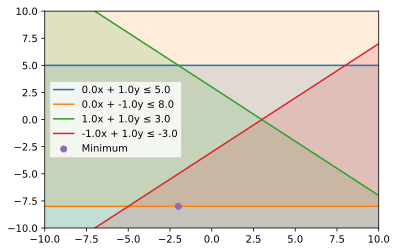

In [10]:
plot_2d_constraints(A1, b1)
y_A1 = max(solution_A1['value'] * a_i + b_i for a_i, b_i in I1)
plt.scatter([solution_A1['value']], [y_A1], zorder=5, label='Minimum')
plt.legend()
plt.show()

## Random constraints
To illustrate some of the cases that the solver encounters, we can sample constraints randomly. These constraints may or may not be feasible.

In [673]:
np.random.seed(2)

In [685]:
A_rand = 10 * np.random.random((5, 2)) - 5
b_rand = 10 * np.random.random(5) - 5

I1_rand, I2_rand = separate_constraints(A_rand, b_rand)
solution_rand = megiddo(I1_rand, I2_rand, -20, 20, debug=False)

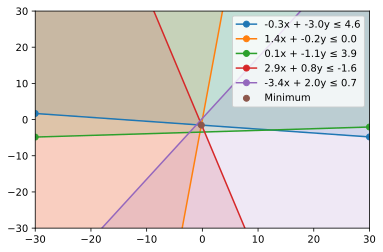

In [686]:
plot_2d_constraints(A_rand, b_rand, xmin=-30, xmax=30, ymin=-30, ymax=30)
if solution_rand['value'] is not None:
    y_rand = max(solution_rand['value'] * a_i + b_i for a_i, b_i in I1_rand)
    plt.scatter([solution_rand['value']], [y_rand], zorder=5, label='Minimum')
    plt.legend()
plt.show()

## References (primarily Megiddo-related)
Mount, David M. ["CMSC 754: Computational Geometry."](http://www.cs.umd.edu/class/spring2020/cmsc754/Lects/lect06-duality.pdf) Lecture Notes, University of Maryland (2020).

Shamos, Michael Ian. ["Computational geometry."](http://euro.ecom.cmu.edu/people/faculty/mshamos/1978ShamosThesis.pdf) Ph. D. thesis, Yale University (1978).

Souvaine, Diane L. ["Linear Programming in 2D."](http://www.cs.tufts.edu/comp/163/notes05/LP.pdf) Lecture Notes, Tufts University (2005).

Megiddo, Nimrod. ["Linear-time algorithms for linear programming in R^3 and related problems."](http://theory.stanford.edu/~megiddo/pdf/lp3.pdf) SIAM journal on computing 12.4 (1983): 759-776.

### BONUS (in progress): Finding the intersection of half-planes with duality
I will likely submit a revised version of this notebook with a full implementation of a less optimal $O(n \log n)$ 2D convex hull algorithm that combines various techniques studied in this course (duality, plane sweep, convex hulls, the Graham scan algorithm). I have started this work below and am currently debugging the merging of half-envelopes.

\begin{align*}
    (a, b) \text{ in primal} \to y &= ax + b \text{ in dual} \\
    (c, d) \text{ in dual} \to y &= -cx + d \text{ in primal}
\end{align*}

In [687]:
def left_turn(triple):
    a, b, c = triple
    return ((b[0] - a[0]) * (c[1] - a[1])) - ((b[1] - a[1]) * (c[0] - a[0])) > 0

def graham_scan_2d(points):
    if len(points) < 3:
        return np.array(points)
    p0 = points[np.argmin(points[:, 0], axis=0)]
    points = points[np.argsort(points[:, 0], axis=0)]
    points = points[np.where((points[:, 0] != p0[0]) &
                             (points[:, 1] != p0[1]))]
    slopes = np.divide(points[:, 1] - p0[1], points[:, 0] - p0[0])
    slope_indices = np.argsort(slopes)
    stack = deque()
    stack.append(p0)
    def fix_stack():
        while (len(stack) > 3 and left_turn([stack[-1], stack[-2], stack[-3]])):
            top = stack.pop()
            stack.pop()
            stack.append(top)
    
    for idx in slope_indices:
        stack.append(points[idx])
        fix_stack()
    fix_stack()
    return np.array(stack)

In [688]:
def dual(points):
    points = np.array(points)
    points[:, 1] = -points[:, 1]
    return points

In [702]:
def half_envelope(hull, upper=True, epsilon=1e-8):
    if hull.size == 0:
        # Empty hull (no upper or lower constraints)
        return {}
    elif hull.shape[0] == 1:
        # One half-plane.
        plane = (hull[0][0], -hull[0][1])
        return {'left': plane, 'right': plane, 'points': []}
    
    p_min_x = tuple(min(hull, key=lambda p: p[0]))
    p_max_x = tuple(max(hull, key=lambda p: p[0]))
    m_upper = (p_max_x[1] -  p_min_x[1]) / (p_max_x[0] -  p_min_x[0])
    b_upper = p_max_x[1] - (m_upper * p_max_x[0])
    # The lower hull in the dual maps to the upper envelope in the primal.
    if upper:
        half_hull = [(x, y) for x, y in hull if y >= m_upper * x + b_upper]
    else:
        half_hull = [(x, y) for x, y in hull if y <= m_upper * x + b_upper]
    #half_hull.append(half_hull[0])
        
    envelope = []
    for idx, (p1, p2) in enumerate(zip(half_hull[:-1], half_hull[1:])):
        #if (p1 == p_min_x and p2 == p_max_x) or (p1 == p_max_x and p2 == p_min_x):
        #    continue
        m = (p2[1] -  p1[1]) / (p2[0] -  p1[0])
        b = p2[1] - (m * p2[0])
        envelope.append((m, -b))
    envelope = sorted(envelope, key=lambda p: p[0])

    if upper:
        left = (p_max_x[0], -p_max_x[1])
        right = (p_min_x[0], -p_min_x[1])
    else:
        left = (p_min_x[0], -p_min_x[1])
        right = (p_max_x[0], -p_max_x[1])
    return {'left': left, 'right': right, 'points': envelope}

In [703]:
lower_envelope = half_envelope(graham_scan_2d(dual(I1_rand)),
                               upper=False)  # "above" constraints (lower envelope)
upper_envelope = half_envelope(graham_scan_2d(dual(I2_rand)),
                               upper=True)   # "below" constraints (upper envelope)

In [704]:
upper_envelope

{'left': (1.6821790988003726, 0.3344624795798813),
 'right': (-3.670276460059175, -1.979725928701796),
 'points': [(-0.4323601350507548, -0.3928447027570049)]}

In [705]:
lower_envelope

{'left': (-0.1080026281190742, -1.5575541647277158),
 'right': (8.29328773764167, -0.0004938623155302401),
 'points': []}

In [706]:
def plot_half_envelope(envelope, xmin, xmax, *args, **kwargs):
    if envelope and not envelope['points']:
        m, b = envelope['left']
        plt.plot([xmin, xmax], [xmin * m + b, xmax * m + b], *args, **kwargs)
    elif envelope and envelope['points']:
        leftmost = (xmin, xmin * envelope['left'][0] + envelope['left'][1])
        rightmost = (xmax, xmax * envelope['right'][0] + envelope['right'][1])
        points = [leftmost, *envelope['points'], rightmost]
        plt.plot([p[0] for p in points], [p[1] for p in points],
                 *args, **kwargs)
    plt.xlim(xmin, xmax)

def plot_envelope(upper, lower, xmin=-10, xmax=10):
    plot_half_envelope(upper, xmin, xmax, color='blue', label='Upper', linewidth=2, marker='')
    plot_half_envelope(lower, xmin, xmax, color='red', label='Lower', linewidth=2, marker='')

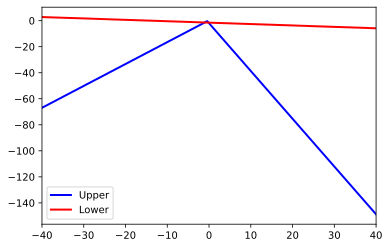

In [707]:
plot_envelope(upper_envelope, lower_envelope, xmin=-40, xmax=40)
plt.legend()
plt.show()

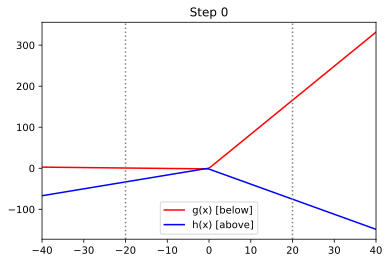

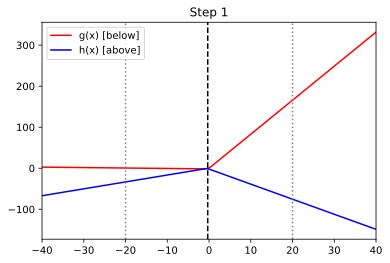

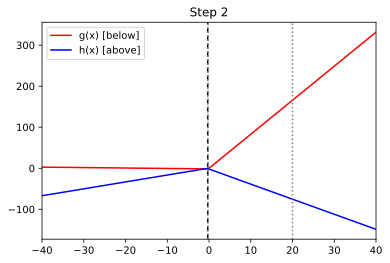

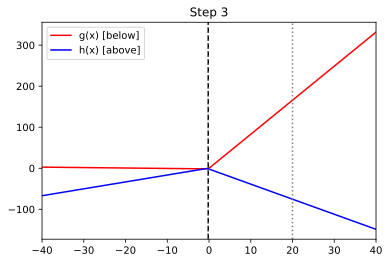

In [708]:
show_megiddo(solution_rand['steps'])

## References
TODO